In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
fake = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main//data/Fake.csv')
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

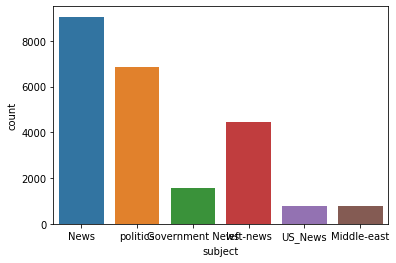

In [ ]:
sns.countplot(x = 'subject',data=fake)

# wordclude

In [ ]:
text = ' '.join(fake['text'].tolist())

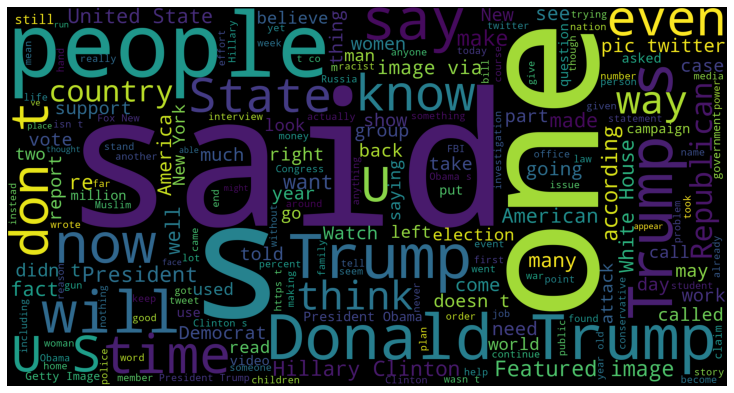

In [ ]:
wordcloud = WordCloud(width=1900, height=1000).generate(text)
fig = plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Real dataset

In [ ]:
true = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main//data/True.csv')
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
text = ' '.join(true['text'].tolist())

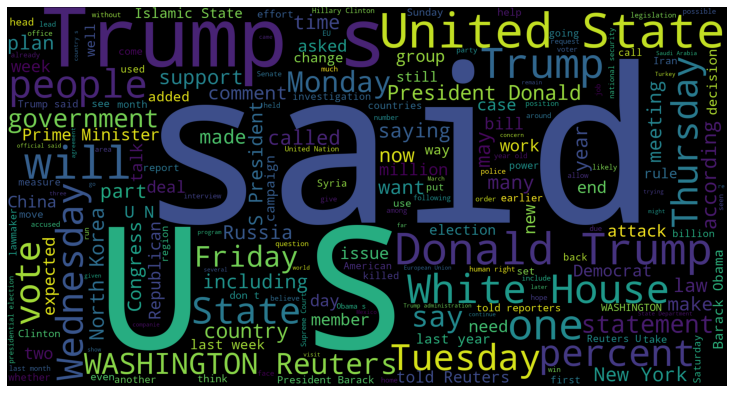

In [ ]:
wordcloud = WordCloud(width=1900, height=1000).generate(text)
fig = plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Cleaning Data

In [ ]:
true.sample(5)

,title,text,subject,date
13581,Danish divers find arm assumed to be that of d...,COPENHAGEN (Reuters) - Divers searching waters...,worldnews,"November 29, 2017"
13402,Libyan PM Sarraj hopes for easing of arms embargo,WASHINGTON (Reuters) - Libyan Prime Minister F...,worldnews,"November 30, 2017"
16667,Deadly air strike hits Syrian government-held ...,BEIRUT (Reuters) - An air raid in the governme...,worldnews,"October 23, 2017"
10398,Exclusive: House Speaker Ryan seeks halt to pr...,WASHINGTON (Reuters) - House Speaker Paul Ryan...,politicsNews,"March 10, 2016"
20319,North Korean threat highlights NATO missile sh...,BRUSSELS (Reuters) - NATO has joined world pow...,worldnews,"September 12, 2017"


In [ ]:

unknown_publishers = []
for index, row in enumerate(true.text.values):
  try:
    record = row.split('-', maxsplit=1)
    record[1
           ]
    assert(len(record[0])<120)
  except:
    unknown_publishers.append(index)

In [ ]:
len(unknown_publishers)

222

In [ ]:
true.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 222, dtype: object

In [ ]:
true.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [ ]:
true = true.drop(8970, axis=0)

In [ ]:
publisher = []
tmp_text = []

for index, row in enumerate(true.text.values):
  if index in unknown_publishers:
    tmp_text.append(row)
    publisher.append('Unknown')

  else:
    record = row.split('-', maxsplit=1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())

In [ ]:
true['publisher']=publisher
true[text] = tmp_text

In [ ]:
#عرض البيانات الحقيقية
true.head()

In [ ]:
#عدد البيانات في البيانات الحقيقية
true.shape

In [ ]:
#البيانات الفارغة من مجموعة البيانات fake
empty_fake_index = [index for index,text in enumerate(fake.text.tolist()) if str(text).strip()==""] 

In [ ]:
# عرض للبيانات الفارغة
fake.iloc[empty_fake_index]

In [ ]:
true['text'] = true['title'] + " " + true['text']
fake['text'] = fake['title'] + " " + fake['text']

In [ ]:
# جعل البيانات في حاله احرف صغيرة
true['text'] = true['text'].apply(lambda x: str(x).lower())
fake['text'] = fake['text'].apply(lambda x: str(x).lower())

## preprocessing Text

In [ ]:
# ضع الاخبار الحقيقية =1 و الاخبار الزائفة =0 في العمود كلاس
true['class'] = 1
fake['class'] = 0

In [ ]:
true.columns

In [ ]:
true = true[['text', 'class']]

In [ ]:
fake = fake[['text', 'class']]

In [ ]:
data = true.append(fake, ignore_index=True)

In [ ]:
#https://github.com/laxmimerit/preprocess_kgptalkie

In [ ]:
!pip install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3

In [ ]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

In [ ]:
import preprocess_kgptalkie as ps

In [ ]:
data['text'] = data['text'].apply(lambda x: ps.remove_special_chars(x))

In [ ]:
ps.remove_special_chars('this ,. @ # is gre@t')

In [ ]:
data.head()

In [ ]:
import gensim

In [ ]:
y = data['class'].values

In [ ]:
X = [d.split() for d in data['text'].tolist()]

In [ ]:
type(X[0])

In [ ]:
print(X[0])

In [ ]:
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, size=DIM, window=10, min_count=1)

In [ ]:
len(w2v_model.wv.vocab)

232476

In [ ]:
w2v_model.wv.most_similar('love')

[('applaud', 0.7173928618431091),
 ('thank', 0.6852817535400391),
 ('admire', 0.6800712943077087),
 ('pray', 0.6673123836517334),
 ('loved', 0.6423624157905579),
 ('appreciate', 0.6415826082229614),
 ('wish', 0.6313284635543823),
 ('bless', 0.6194263696670532),
 ('loves', 0.6133692264556885),
 ('beautiful', 0.6119512319564819)]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [ ]:
X = tokenizer.texts_to_sequences(X)

In [ ]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'a': 4,
 'and': 5,
 'in': 6,
 'that': 7,
 'on': 8,
 'for': 9,
 's': 10,
 'is': 11,
 'he': 12,
 'said': 13,
 'trump': 14,
 'it': 15,
 'with': 16,
 'was': 17,
 'as': 18,
 'his': 19,
 'by': 20,
 'has': 21,
 'be': 22,
 'have': 23,
 'not': 24,
 'from': 25,
 'this': 26,
 'at': 27,
 'are': 28,
 'who': 29,
 'us': 30,
 'an': 31,
 'they': 32,
 'i': 33,
 'but': 34,
 'we': 35,
 'would': 36,
 'president': 37,
 'about': 38,
 'will': 39,
 'their': 40,
 'had': 41,
 'you': 42,
 't': 43,
 'been': 44,
 'were': 45,
 'people': 46,
 'more': 47,
 'or': 48,
 'after': 49,
 'which': 50,
 'she': 51,
 'her': 52,
 'one': 53,
 'if': 54,
 'its': 55,
 'out': 56,
 'all': 57,
 'what': 58,
 'new': 59,
 'state': 60,
 'when': 61,
 'also': 62,
 'up': 63,
 'there': 64,
 'over': 65,
 'no': 66,
 'house': 67,
 'reuters': 68,
 'donald': 69,
 'our': 70,
 'states': 71,
 'clinton': 72,
 'obama': 73,
 'government': 74,
 'can': 75,
 'just': 76,
 'him': 77,
 'so': 78,
 'than': 79,
 'republican': 80,
 '

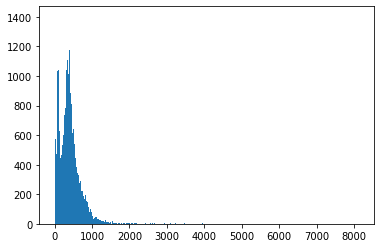

In [ ]:
plt.hist([len(x) for x in X], bins = 700)
plt.show()

In [ ]:
nos = np.array([len(x) for x in X])
len(nos[nos>1000])

1592

In [ ]:
maxlen = 1000
X = pad_sequences(X, maxlen=maxlen)

In [ ]:
len(X[101])

1000

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [ ]:
def get_weight_matrix(model):
  weight_matrix = np.zeros((vocab_size, DIM))

  for word, i in vocab.items():
    weight_matrix[i] = model.wv[word]

  return weight_matrix

In [ ]:
embedding_vectors = get_weight_matrix(w2v_model)

In [ ]:
embedding_vectors.shape

(232477, 100)

In [ ]:

model = Sequential()
model.add(Embedding(vocab_size, output_dim=DIM, weights = [embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         23247700  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 23,365,077
Trainable params: 117,377
Non-trainable params: 23,247,700
_________________________________________________________________


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y) 

In [ ]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
737/737 [==============================] - 48s 56ms/step - loss: 0.1120 - acc: 0.9585 - val_loss: 0.0306 - val_acc: 0.9923
Epoch 2/6
737/737 [==============================] - 41s 55ms/step - loss: 0.0365 - acc: 0.9891 - val_loss: 0.0188 - val_acc: 0.9954
Epoch 3/6
737/737 [==============================] - 48s 65ms/step - loss: 0.0168 - acc: 0.9947 - val_loss: 0.0241 - val_acc: 0.9939
Epoch 4/6
737/737 [==============================] - 47s 64ms/step - loss: 0.0122 - acc: 0.9963 - val_loss: 0.0144 - val_acc: 0.9962
Epoch 5/6
737/737 [==============================] - 42s 57ms/step - loss: 0.0090 - acc: 0.9977 - val_loss: 0.0216 - val_acc: 0.9946
Epoch 6/6
737/737 [==============================] - 41s 56ms/step - loss: 0.0066 - acc: 0.9983 - val_loss: 0.0196 - val_acc: 0.9951


In [ ]:
y_pred = (model.predict(X_test) >=0.5).astype(int)

351/351 [==============================] - 8s 20ms/step


In [ ]:
accuracy_score(y_test, y_pred)

0.9939420935412027

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5872
           1       0.99      1.00      0.99      5353

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [ ]:
x = ['this is a news']

In [ ]:
X_test

array([[    0,     0,     0, ...,   787,    80, 17614],
       [    0,     0,     0, ...,   478,  4369, 16667],
       [    0,     0,     0, ...,   198,   177,  2105],
       ...,
       [    0,     0,     0, ...,     3,     1,   217],
       [    0,     0,     0, ...,     1,    30,   190],
       [    0,     0,     0, ...,    20, 15641,   189]], dtype=int32)

In [ ]:
x = ['this is the news']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x, maxlen=maxlen)

In [ ]:
(model.predict(x) >=0.5).astype(int)

1/1 [==============================] - 0s 43ms/step


array([[0]])